# Forecast The Global Household Electric Power Consumption

In [1]:
import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sklearn

## Explore The Data

In [2]:
data = pd.read_csv("../data/household_power_consumption.txt", sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')

In [3]:
data = data.resample("H").sum()

In [4]:
data.shape

(34589, 7)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34589 entries, 2006-12-16 17:00:00 to 2010-11-26 21:00:00
Freq: H
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Global_active_power    34589 non-null  float64
 1   Global_reactive_power  34589 non-null  float64
 2   Voltage                34589 non-null  float64
 3   Global_intensity       34589 non-null  float64
 4   Sub_metering_1         34589 non-null  float64
 5   Sub_metering_2         34589 non-null  float64
 6   Sub_metering_3         34589 non-null  float64
dtypes: float64(7)
memory usage: 2.1 MB


**Attribute Information:**

1. **date**: Date in format dd/mm/yyyy  
2. **time**: time in format hh:mm:ss  
3. **globalactivepower**: household global minute-averaged active power (in kilowatt)  
4. **globalreactivepower**: household global minute-averaged reactive power (in kilowatt)  
5. **voltage**: minute-averaged voltage (in volt)  
6. **global_intensity**: household global minute-averaged current intensity (in ampere)  
7. **submetering1**: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).  
8. **submetering2**: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.  
9. **submetering3**: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner  

In [6]:
data.head(5)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:00:00,152.024,8.244,8447.18,651.6,0.0,19.0,607.0
2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,0.0,403.0,1012.0
2006-12-16 19:00:00,204.014,5.114,13993.95,870.2,0.0,86.0,1001.0
2006-12-16 20:00:00,196.114,4.506,14044.29,835.0,0.0,0.0,1007.0
2006-12-16 21:00:00,183.388,4.600,14229.52,782.8,0.0,25.0,1033.0


In [7]:
data.isna().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [8]:
from sklearn.impute import SimpleImputer
# impute missing
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
data = pd.DataFrame(imp.fit_transform(data), index=data.index, columns=data.columns)

In [9]:
data.isna().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

There is 2075259 records from 2006-12-16 to 2010-11-26 with 25979 of missing records. We simply fill with mean-value.  
We focus on forecasting the Global_active_power here, which is the **true** or **real** or **actual power** dissipated in the circuit.

In [10]:
from datetime import datetime as dt
import time

def toYearFraction(date):
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch
    
    year = date.year
    startOfThisYear = dt(year=year, month=1, day=1)
    startOfNextYear = dt(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction

In [11]:
# create decimal_time column for time-dependent calculation
data = data.reset_index()
data = data.set_index("dt", drop=False)
data["decimal_time"] = data["dt"].apply(lambda x: toYearFraction(x))
del data["dt"]
data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,decimal_time
dt,,,,,,,,
2006-12-16 17:00:00,152.024,8.244,8447.18,651.6,0.0,19.0,607.0,2006.958105
2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,0.0,403.0,1012.0,2006.958219
2006-12-16 19:00:00,204.014,5.114,13993.95,870.2,0.0,86.0,1001.0,2006.958333
2006-12-16 20:00:00,196.114,4.506,14044.29,835.0,0.0,0.0,1007.0,2006.958447
2006-12-16 21:00:00,183.388,4.600,14229.52,782.8,0.0,25.0,1033.0,2006.958562


## Let's Forecast !

First of all, let's revise some concept of the time series.  

Time series can be decomposed as three components, which are **drift**, **seasonal**, and **noise**

$$ y(t) = \mathrm{drift} + \mathrm{seasonal} + \mathrm{noise}. $$

- **Drift**: An overall trend, such as 
$$ y(t) = \mu t. $$
Note that the trend no need to be a linear, it can be quadratic or polynomial or whatever! 

- **Seasonality**: A periodic behavior, such as
$$ y(t) = A\sin(2\pi ft) + B\cos(2\pi ft). $$
where, $f$ is the frequency

- **Noise**: The part of the time series remaining after removing drift and seasonality. It is the residual of a model containing drift and seasonality.

Our approach will be to identify the first two terms to create a baseline model, leaving behind the residuals or noise.

**The steps to time series forecasting:**
1. Plot the time series to see if there is any overall trends and seasonality.
1. Detrend the time series by removing drift and seasonality.
1. Fit a baseline model and calculate the residuals.
1. Analyze the resulting residuals and generate features from the residuals.
1. Train a machine learning model to forecast/predict residuals and add back the baseline model.

## Deal with the Drift

<AxesSubplot:xlabel='dt', ylabel='Minute average power kW'>

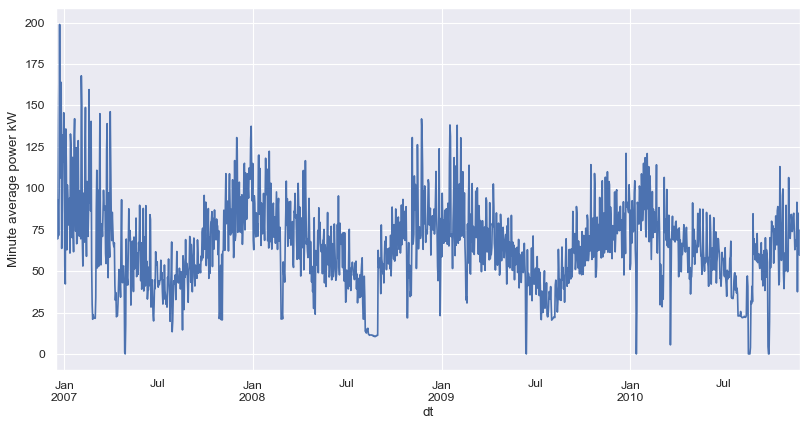

In [12]:
power = data['Global_active_power']
plt.figure(figsize=(12, 6), dpi=80)
plt.ylabel('Minute average power kW')
power.resample("D").mean().plot()

According to the plots, it looks like a stationary TS with seasonality. However, we can create a simple model to capture drift, if it exists, even if we can't notice it.

In [13]:
# We can customize transformer to select the index of df
from sklearn.base import BaseEstimator, TransformerMixin

class ColumnSelectTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns, need_reshape=False):
        self.columns = columns
        self.need_reshape = need_reshape

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        if self.need_reshape:
            return X[self.columns].values.reshape(-1,1)
        else:
            return X[self.columns]

class IndexSelector(BaseEstimator, TransformerMixin):
    def __init__(self):
        """Return indices of a data frame for use in other estimators."""
        pass
    
    def fit(self, df, y=None):
        return self
    
    def transform(self, df):
        indices = df.index
        return indices.values.reshape(-1, 1)

In [14]:
def ts_train_test_split(df, cutoff, target):
    """Perform a train/test split on a data frame based on a cutoff date."""
    
    ind = df.index < str(cutoff)
    
    df_train = df.loc[ind]
    df_test = df.loc[~ind]
    y_train = df.loc[ind, target]
    y_test = df.loc[~ind, target]
    
    return df_train, df_test, y_train, y_test

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

# perform train/test split
cutoff = 2010
df_train, df_test, y_train, y_test = ts_train_test_split(data, cutoff, 'Global_active_power')

# construct and train pipeline
trend_col = ColumnSelectTransformer("decimal_time", need_reshape=True)
poly = PolynomialFeatures(degree=1)
lr = LinearRegression()
trend_pipe = Pipeline([
    ("select_col", trend_col),
    ("drift", poly)
])
pipe = Pipeline([('trend_feature', trend_pipe),
                 ('regressor', lr)])
pipe.fit(df_train, y_train)

# make predictions
y_pred = pipe.predict(data)
resd = power - y_pred
print("Test set R^2: {:g}".format(pipe.score(df_test, y_test)))

Test set R^2: 0.00321514


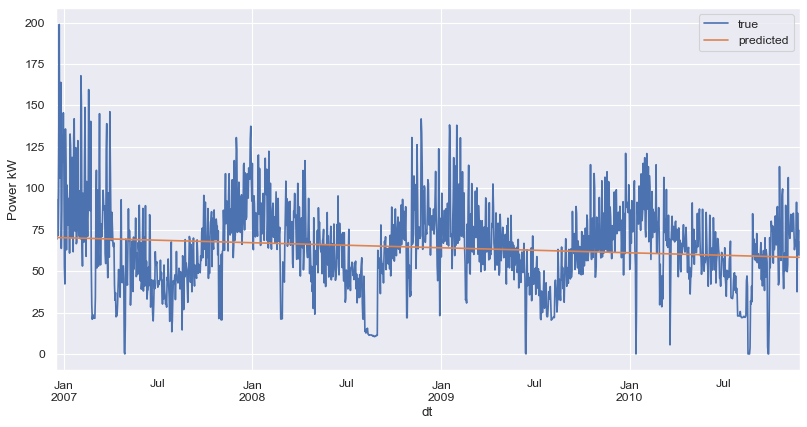

In [16]:
y_pred_df = pd.DataFrame(y_pred, index=data.index, columns=["pred_power"])
plt.figure(figsize=(12, 6), dpi=80)
plt.ylabel('Power kW')
power.resample("D").mean().plot()
y_pred_df["pred_power"].resample("D").mean().plot()
plt.legend(['true', 'predicted'])

<AxesSubplot:xlabel='dt', ylabel='Residuals Power kW'>

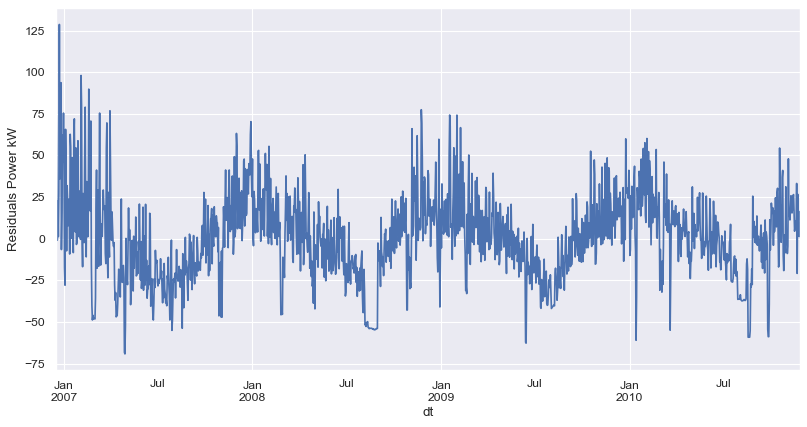

In [17]:
plt.figure(figsize=(12, 6), dpi=80)
plt.ylabel('Residuals Power kW')
resd.resample("D").mean().plot()

As the result, the drift is pretty small and the residuals look exactly like the full series itself haha. The R^2 is about -0.0012.  
So, I decide to ignore it. hahaha.  
Let's see what happened with the seasonality.

## Time to crack the seasonality !!**

As your math teacher told you. _"Any signal can be represented as a linear superposition of sines and cosines of varying frequencies $f_n$ and amplitudes $A_n$ and $B_n$"_,

$$ y(t) = \sum_n \left(A_n \sin(2\pi f_n t) + B_n\cos(2 \pi f_n t) \right). $$

Sometime (most of the time), we want to know what is the dominant frequencies that make up a time series.

Here are when the **Fourier transform** comes to save our life.  

The Fourier transform  let us transforme our signal in the time domain into the frequency domain. Since we will be working with discrete data; the signal is sampled at discrete points in time, we will use the **discrete Fourier transform**. For $N$ uniformly sampled time series $y_n$, the transform is defined as

$$ Y_k = \sum^{N-1}_{n=0} y_n e^{-\frac{2\pi i}{N} kn}, $$

$$ Y_k = \sum^{N-1}_{n=0} y_n \left[\cos\left(\frac{2\pi i}{N} kn\right) - i\sin\left(\frac{2\pi i}{N} kn\right) \right], $$

and $i$ is the imaginary number. The term $Y_k$ is the Fourier transform value for a frequency of $k$ cycles in $N$ samples; it is a complex number that represents both the amplitude and phase for its respective sinusoidal component. The amplitude for the frequency $k/N$ is 

$$ |Y_k|/N = \frac{\sqrt{\mathrm{Re}(Y_k)^2 + \mathrm{Im}(Y_k)^2}}{N}. $$

The most common algorithm used to compute the discrete Fourier transform is the fast Fourier transform (FFT). The algorithm makes use of matrix factorization to have a time complexity of $O(n\log n)$ as opposed to the naive  $O(n^2)$ implementation. Note, the time series needs to be uniformly sampled. The `scipy.fftpack` provides the FFT algorithm. Let's use FFT to determine the contributed frequencies in the signal below.

Enough with math

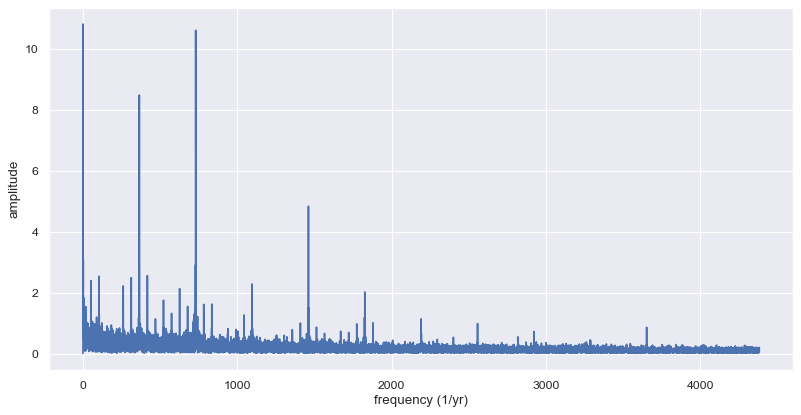

In [18]:
from scipy import fftpack

Y = fftpack.fft(power.values - power.mean())
t_span = toYearFraction(power.index[-1]) - toYearFraction(power.index[0])
f = np.linspace(0, len(Y), len(Y))/t_span

def plot_fft(fraction):
    plt.figure(figsize=(12, 6), dpi=80)
    plt.plot(f[:len(Y)//fraction], np.abs(Y[:len(Y)//fraction])/len(Y));
    plt.xlabel('frequency (1/yr)')
    plt.ylabel('amplitude');

plot_fft(2)

In [19]:
# get the most dominant frequencies
def most_dominant_fft(top_n, fraction):
    fft_top_list = zip(f[:len(Y)//fraction], np.abs(Y[:len(Y)//fraction])/len(Y))
    return sorted(fft_top_list, key=lambda t: t[1], reverse=True)[:top_n]

most_dominant_fft(15, 2)

[(1.0138008641394267, 10.802259360283962),
 (730.4435226124571, 10.59791996627462),
 (365.22176130622853, 8.474101293325866),
 (730.6969728284919, 7.41516883652946),
 (1461.1404954409488, 4.82833198115079),
 (365.47521152226335, 3.6511687515378024),
 (730.1900723964222, 3.5543317003225363),
 (2.0276017282788534, 3.087442860874487),
 (729.4297217483175, 2.9084817223927533),
 (364.2079604420891, 2.821379720903519),
 (366.2355621703679, 2.6950463468457464),
 (417.432505809409, 2.553231832144268),
 (104.42148900636097, 2.531147891850881),
 (313.011016803048, 2.485896305371202),
 (52.210744503180486, 2.3889565919014046)]

In [20]:
ff_list = [1, 2, 365, 730, 1461]

Add our finding in the model !

$$ y(t) = A + B\sin(2\pi f_1 t) + C\cos(2\pi f_2 t) + D\sin(2\pi f_3 t) + E\cos(2\pi f_4 t), $$

where $t$ in expressed in units of years.

Now, we got the most dominant frequencies that make up the series. I interpreted the numbers and found that it's a lot that made sense. The pattern of household consumption appears every year, every day, every half-day, and every quarter of a day. Next, let's create Fourier features and see is the residauls look better!

In [21]:
from sklearn.base import BaseEstimator, TransformerMixin

class FourierComponents(BaseEstimator, TransformerMixin):
    def __init__(self, freqs):
        """Create features based on sin(2*pi*f*t) and cos(2*pi*f*t)."""
        self.freqs = freqs
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        Xt = np.zeros((X.shape[0], 2*len(self.freqs)))
        
        for i, f in enumerate(self.freqs):

            Xt[:, 2*i]= np.cos(2*np.pi*f*X.values).reshape(-1)
            Xt[:, 2*i + 1] = np.sin(2*np.pi*f*X.values).reshape(-1)
    
        return Xt

In [22]:
# construct and train pipeline
from sklearn.pipeline import FeatureUnion

# perform train/test split
cutoff = 2010
df_train, df_test, y_train, y_test = ts_train_test_split(data, cutoff, 'Global_active_power')

# construct and train pipeline

trend_col = ColumnSelectTransformer("decimal_time", need_reshape=True)
poly = PolynomialFeatures(degree=1)
trend_pipe = Pipeline([('trend_col', trend_col),
                 ('drift', poly),
                 ])

fourier_col = ColumnSelectTransformer("decimal_time")
fourier = FourierComponents(ff_list)
seasonal_pipe = Pipeline([("fourier_col", fourier_col),
                    ("fourier", fourier)])


feature_union = FeatureUnion([
    ("trend_feature", trend_pipe),
    ("seasonal_feature", seasonal_pipe)
])

# construct and train pipeline
lr = LinearRegression()
baseline = Pipeline([
    ('feature_union', feature_union),
    ('regressor', lr)
])

baseline.fit(df_train, y_train)
# make predictions
y_pred = baseline.predict(data)
resd = power - y_pred
print("Test set R^2: {:g}".format(baseline.score(df_test, y_test)))

Test set R^2: 0.256006


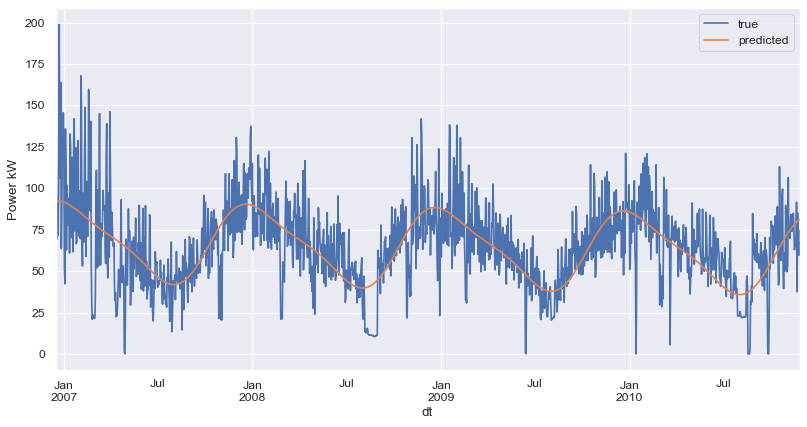

In [23]:
y_pred_df = pd.DataFrame(y_pred, index=data.index, columns=["pred_power"])
plt.figure(figsize=(12, 6), dpi=80)
plt.ylabel('Power kW')
power.resample("D").mean().plot()
y_pred_df["pred_power"].resample("D").mean().plot()
plt.legend(['true', 'predicted'])

<AxesSubplot:xlabel='dt', ylabel='Residuals Power kW'>

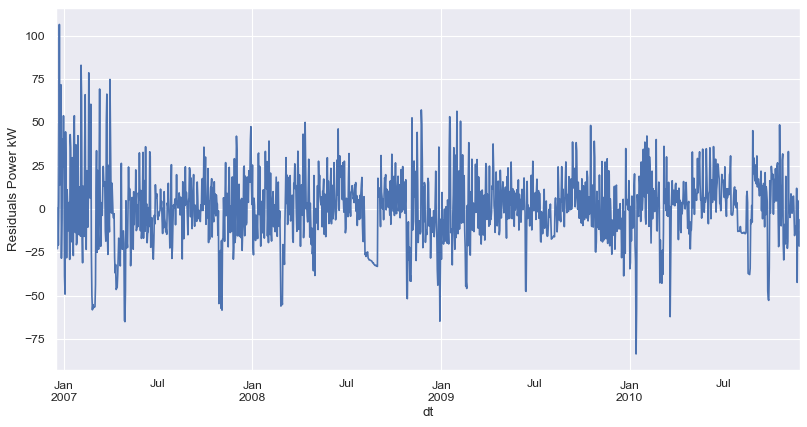

In [24]:
plt.figure(figsize=(12, 6), dpi=80)
plt.ylabel('Residuals Power kW')
resd.resample("D").mean().plot()

Wow, it looks more stationary now!

## Noisy

## Modeling noise

Particulary, past values of times series are correlated to current values.  This is known as **autocorrelation**

To understand the autocorrelation, we should think about:

* **Covariance**: A measure of _joint_ variability of two variables,
$$ \mathrm{cov}(X, Y) = E[(X - E[X])(Y - E[Y])] =  \frac{1}{N} \sum^{n}_{i=1}(x_i - E[X])(y_i - E[Y]). $$

* **Variance**: A measure of the variability of a variable with _itself_; the special case of the covariance,
$$ \mathrm{var}(X) =  \mathrm{cov}(X, X) = E[(X - E[X])^2] = \frac{1}{N} \sum^{n}_{i=1}(x_i - E[X])^2. $$ 

* **Standard Deviation**: The square root of the variance,
$$ \sigma_X = \sqrt{\mathrm{var}(X)}. $$

* **Correlation**: The normalized covariance that ranges from -1 to 1,
$$\rho(X, Y) = \frac{\mathrm{cov}(X, Y)}{\sigma_X \sigma_Y}. $$ 

Three important values and meanings of the correlation coefficient are:

1. If $\rho(X, Y) = 1$, then the two variables are completely linear correlated; an increase in one corresponds to a linear increase of the other.
1. If $\rho(X, Y) = 0$, then the two variables are uncorrelated. Higher values of one variable does not necessarily correspond to higher or lower values of the other.
1. If $\rho(X, Y) = -1$, then the two variables are completely linear anti-correlated; an increase in one corresponds to a linear decrease of the other.

With the correlation coefficient, we can now mathematically define and better understand the autocorrelation of a signal. The autocorrelation as a function of the duration of the lag is defined as

$$ R(\tau) =  \frac{\mathrm{cov}(y(t), y(t-\tau))}{\sigma_{y} \sigma_{y}} = \frac{\gamma(\tau)}{\sigma^2_{y}} = \rho(y(t), y(t-\tau)), $$

where $\tau$ is the duration of the lag/delay and $\gamma$ is the autocovariance function. Since we are working with discrete data, we can define the lag with respect to the number of time steps $k$,

$$ R(k) = \frac{\gamma(k)}{\sigma_{y}^2} = \rho(y_t, y_{t-k}). $$

**In conclusion the autocorrelation is just a correlation between present value and the past of itself (lag)**

***Let's see the correlation of our time series***

The data is too big, so I sample some month to see the autocorrelation

(0.0, 100.0)

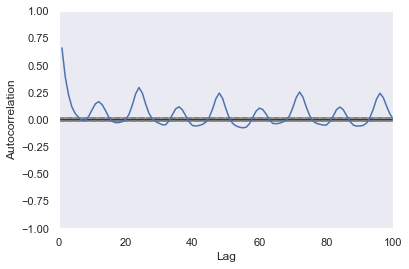

In [25]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(resd)
plt.xlim([0, 100])

(0.0, 24.0)

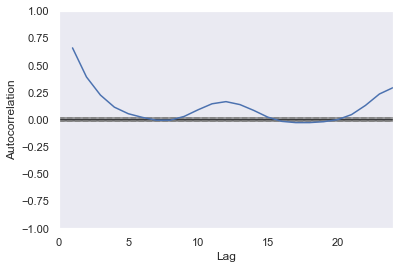

In [26]:
autocorrelation_plot(resd)
plt.xlim([0, 24])

In [27]:
resd.autocorr(1)

0.6594171372049703

**After decide the number of lags, we will calculate our noisy features**, which are:

* **Rolling Window Average**: The average is calculated for a window of $k$ previous points.

$$ MA_t = \frac{1}{k} \sum^{n}_{n-k} y_k. $$

* **Exponential Moving Average**: All points are included in calculating the average but are weighted using an exponential decay. In other words, values further in the past contribute less to the moving average than recent points. A nice property of the exponential moving average is that the moving average value can be calculated with only the current time series value and the previous exponential moving average value.

$$ EMA_t = \alpha y_t + (1 - \alpha) EMA_{t-1}, $$

where $\alpha$ ranges from 0 to 1 and scales the strength of the contribution of past values. The value of $\alpha$ is related to the half-life of the weights, the time for the weights to drop half of their value,

$$ \alpha = 1 - \exp\left[-\frac{\ln(2)}{t_{1/2}}\right], $$

where $t_{1/2}$ is the half-life. Note, while we have discussed rolling window and exponential moving _averages_, other values can be calculated for other statistics. 

In the visualizations below, you can control the window size and half-life of the rolling window and exponentially weighted average of the residuals. Notice how applying moving averages smooths out the residuals. These moving averages are sometimes used to smooth out data.

In [28]:
class ResidualFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, window=24):
        """Generate features based on window statistics of past noise/residuals."""
        self.window = window
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        df = pd.DataFrame()
        df['residual'] = pd.Series(X, index=X.index)
        df['prior'] = df['residual'].shift(1)
        df['mean'] = df['residual'].rolling(window=self.window).mean()
        df['std'] = df['residual'].rolling(window=self.window).std()
        df['max'] = df['residual'].rolling(window=self.window).max()
        df['min'] = df['residual'].rolling(window=self.window).min()
        df['diff'] = df['residual'].diff().rolling(window=self.window).mean()
        df = df.fillna(method='bfill')
        
        return df

In [29]:
from sklearn.metrics import r2_score, mean_squared_error

# create and train residual model
resd_train = y_train - baseline.predict(df_train)
residual_feats = ResidualFeatures(window=20)
residual_model = Pipeline([('residual_features', residual_feats), ('regressor', LinearRegression())])
residual_model.fit(resd_train.iloc[:-24], resd_train.shift(-24).dropna())

# evaluate model
resd_pred = residual_model.predict(resd) # prediction for all time steps
resd_pred = pd.Series(resd_pred, index=data.index)
resd_pred = resd_pred.shift(10).dropna() # shift predicted values to matching time step
resd_pred_test = resd_pred.loc["2010":] # evaluate only on 2010 values
print("Residual test set R^2: {:g}".format(r2_score(resd.loc["2010":], resd_pred_test)))

Residual test set R^2: -0.0417393


<AxesSubplot:xlabel='dt', ylabel='Residuals Power kW'>

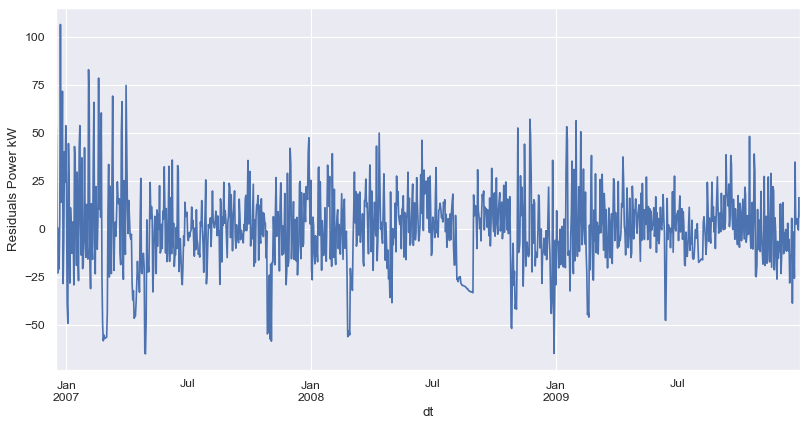

In [30]:
plt.figure(figsize=(12, 6), dpi=80)
plt.ylabel('Residuals Power kW')
resd_train.resample("D").mean().plot()

In [31]:
from sklearn.base import RegressorMixin

class FullModel(BaseEstimator, RegressorMixin):
    def __init__(self, baseline, residual_model, steps=24):
        """Combine a baseline and residual model to predict any number of steps in the future."""
        
        self.baseline = baseline
        self.residual_model = residual_model
        self.steps = steps
        
    def fit(self, X, y):
        self.baseline.fit(X, y)
        resd = y - self.baseline.predict(X)
        self.residual_model.fit(resd.iloc[:-self.steps], resd.shift(-self.steps).dropna())
                
        return self
    
    def predict(self, X):
        y_b = pd.Series(self.baseline.predict(X), index=X.index)
        resd = X['Global_active_power'] - y_b
        resd_pred = pd.Series(self.residual_model.predict(resd), index=X.index)
        resd_pred = resd_pred.shift(self.steps)
        y_pred = y_b + resd_pred
        
        return y_pred
    
# construct and train full model
full_model = FullModel(baseline, residual_model, steps=24)
full_model.fit(df_train, y_train)

# make predictions
y_pred = full_model.predict(data)
resd = power - y_pred
ind = resd["2010":].index
print("Test set R^2: {:g}".format(r2_score(power.loc[ind], y_pred.loc[ind])))
print("Test set mean rmse: {:g}".format(np.sqrt(mean_squared_error(power.loc[ind], y_pred.loc[ind]) / power.loc[ind].mean())))

Test set R^2: 0.301039
Test set mean rmse: 5.08165


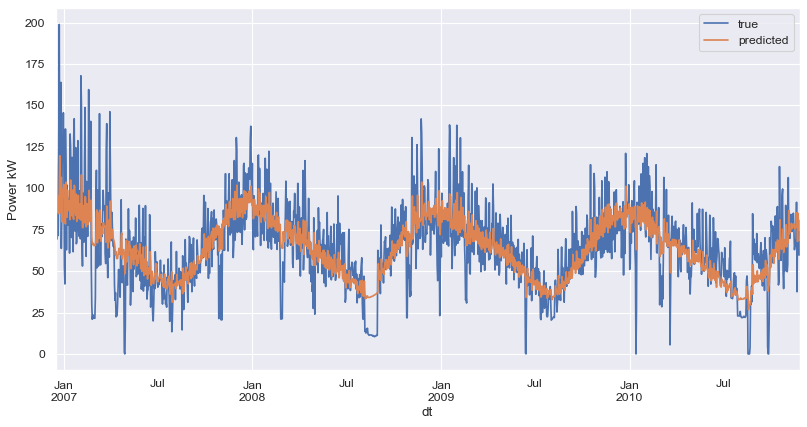

In [32]:
y_pred_df = pd.DataFrame(y_pred, index=data.index, columns=["pred_power"])
plt.figure(figsize=(12, 6), dpi=80)
plt.ylabel('Power kW')
power.resample("D").mean().plot()
y_pred_df["pred_power"].resample("D").mean().plot()
plt.legend(['true', 'predicted'])

<AxesSubplot:xlabel='dt', ylabel='Residuals Power kW'>

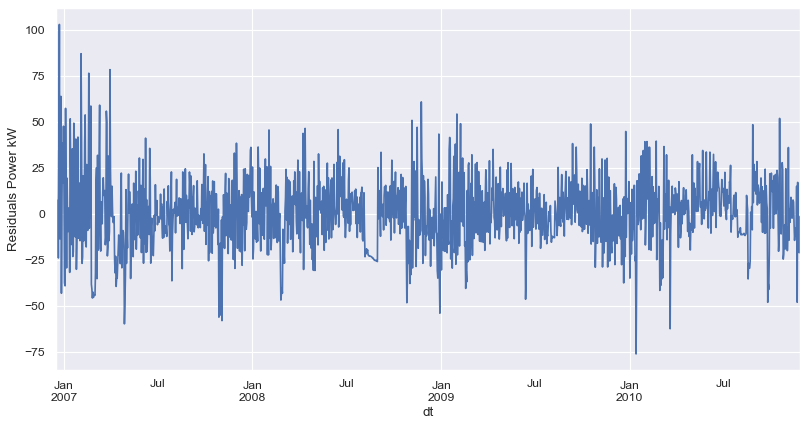

In [33]:
plt.figure(figsize=(12, 6), dpi=80)
plt.ylabel('Residuals Power kW')
resd.resample("D").mean().plot()

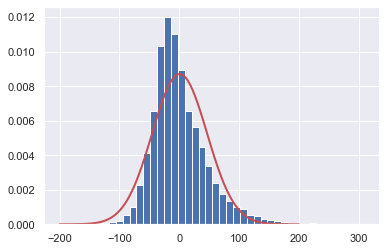

In [34]:
from scipy.stats import norm

mu = resd.mean()
sigma = resd.std(ddof=1)
dist = norm(mu, sigma)
x = np.linspace(-200, 200, 100)
f = dist.pdf(x)

resd.hist(bins=40, density=True)
plt.plot(x, f, '-r', linewidth=2);

(0.0, 100.0)

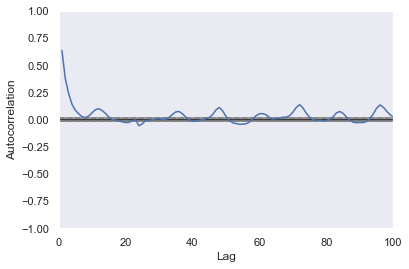

In [35]:
autocorrelation_plot(resd.dropna())
plt.xlim([0, 100])